In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imghdr
from torchvision.transforms import v2 as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models
import torch.optim as optimIn the third setup, the model was trained using a combination of the DMID and INbreast datasets and evaluated on the MIAS dataset. The Macro F1 score achieved in this setting was 75.56%, which is comparatively better than the second experiment, still this showcases a significant deop comparing to the baseline experiments obtaining 94.5% of Macro F1 score in inter dataset experiments. This performance degradation can primarily be attributed to the distinctive characteristics of the MIAS dataset. MIAS is being considered a relatively simple and low-variability dataset, appears to be easier to classify when the model is trained on richer and more complex datasets like INbreast and DMID. The experimental setup allows the model to learn robust low- and mid-level features, which assist generalizing well to MIAS. Surprisingly, the AUC score is highest among all experiments for this setup with a score of 90.79 reflects that the proposed model can generate more false positives when it is applied to MIAS dataset due to the more complex features from INbreast and DMID which is not available in MIAS.

from tqdm import tqdm
import torch
import torch.nn as nn
import pickle
import os
import random
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

# Define GPU device - We will run our model on GPU
gpu_device = torch.device("cuda")

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_36/2644270403.py:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
# Step 1: Load the CSV
csv_path = '/kaggle/input/cassava-leaf-disease-classification/train.csv'
data_dir = '/kaggle/input/cassava-leaf-disease-classification/train_images'
df = pd.read_csv(csv_path)

In [5]:
# Step 2: Split the DataFrame (stratified by label)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [6]:
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")

Train samples: 17117, Val samples: 2140, Test samples: 2140


In [7]:
# Step 3: Define transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
# Step 4: Dataset class that loads image by path on the fly
class CassavaLeafDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)  # pandas DataFrame
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_id'])
        image = Image.open(img_path).convert('RGB')
        label = row['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
# Step 5: Create datasets
train_dataset = CassavaLeafDataset(train_df, data_dir, transform=transform_train)
val_dataset = CassavaLeafDataset(val_df, data_dir, transform=transform_val_test)
test_dataset = CassavaLeafDataset(test_df, data_dir, transform=transform_val_test)


In [10]:
# Step 6: Check class distribution in train set
train_labels = [label for _, label in train_dataset]
label_counts = Counter(train_labels)

print("Class distribution in training set:")
for label, count in label_counts.items():
    print(f"Class {label}: {count} samples")

Class distribution in training set:
Class 4: 2061 samples
Class 3: 10526 samples
Class 1: 1751 samples
Class 2: 1909 samples
Class 0: 870 samples


In [11]:
from torch.utils.data import ConcatDataset
import random

# Count samples per class in training set
label_counts = train_df['label'].value_counts().to_dict()
max_count = max(label_counts.values())

# List to store balanced per-class datasets
balanced_datasets = []

# For each class, oversample
for label, count in label_counts.items():
    df_label = train_df[train_df['label'] == label].copy()

    # Add the original dataset (with augmentations)
    original_ds = CassavaLeafDataset(df_label, data_dir, transform=transform_train)
    balanced_datasets.append(original_ds)

    # Compute how many more samples needed
    num_extra = max_count - count
    if num_extra > 0:
        extra_indices = random.choices(df_label.index.tolist(), k=num_extra)
        df_extra = df_label.loc[extra_indices].reset_index(drop=True)
        extra_ds = CassavaLeafDataset(df_extra, data_dir, transform=transform_train)
        balanced_datasets.append(extra_ds)

# Concatenate all to make one balanced training dataset
balanced_train_dataset = ConcatDataset(balanced_datasets)

# Optional: Check if the dataset is balanced now
from collections import Counter

all_labels = []
for _, label in balanced_train_dataset:
    all_labels.append(label)

balanced_counts = Counter(all_labels)
print("\nBalanced class distribution:")
for label, count in sorted(balanced_counts.items()):
    print(f"Class {label}: {count} samples")



Balanced class distribution:
Class 0: 10526 samples
Class 1: 10526 samples
Class 2: 10526 samples
Class 3: 10526 samples
Class 4: 10526 samples


In [13]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

In [15]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
val_dataset = CassavaLeafDataset(val_df, data_dir, transform=transform_val_test)
test_dataset = CassavaLeafDataset(test_df, data_dir, transform=transform_val_test)

# Create data loaders
train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [19]:
# Training function with early stopping and loss plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_loss, 4)} | Validation Loss : {round(val_loss, 4)} | Train Accuracy : {round(train_acc * 100, 2)}% | Validation Accuracy : {round(val_acc * 100, 2)}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            print("Saving model....")
            torch.save(model.state_dict(), "resnet152_best_model.pt")  # Save the best model
        else:
            patience_counter += 1  # Increment counter if no improvement
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [18]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='macro')
    auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

    # Print
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


**RESNET-152**

In [20]:
# Load pre-trained ResNet-152
model = models.resnet152(pretrained=True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 191MB/s] 


In [21]:
# Modify the classifier to match the number of classes (2 in your case)
num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

Epoch 1/100 - Validation: 100%|██████████| 67/67 [00:12<00:00,  5.58it/s]


--> Epoch Number : 1 | Training Loss : 0.1024 | Validation Loss : 0.8137 | Train Accuracy : 96.42% | Validation Accuracy : 81.5%
Saving model....


Epoch 2/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.68it/s]


--> Epoch Number : 2 | Training Loss : 0.0878 | Validation Loss : 0.9315 | Train Accuracy : 96.98% | Validation Accuracy : 80.47%


Epoch 3/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.81it/s]


--> Epoch Number : 3 | Training Loss : 0.077 | Validation Loss : 0.8579 | Train Accuracy : 97.3% | Validation Accuracy : 83.27%


Epoch 4/100 - Validation: 100%|██████████| 67/67 [00:12<00:00,  5.48it/s]


--> Epoch Number : 4 | Training Loss : 0.0717 | Validation Loss : 0.8465 | Train Accuracy : 97.63% | Validation Accuracy : 83.83%


Epoch 5/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.72it/s]


--> Epoch Number : 5 | Training Loss : 0.0681 | Validation Loss : 0.9139 | Train Accuracy : 97.69% | Validation Accuracy : 82.62%


Epoch 6/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.60it/s]


--> Epoch Number : 6 | Training Loss : 0.0583 | Validation Loss : 0.982 | Train Accuracy : 97.94% | Validation Accuracy : 80.65%
Early stopping triggered.


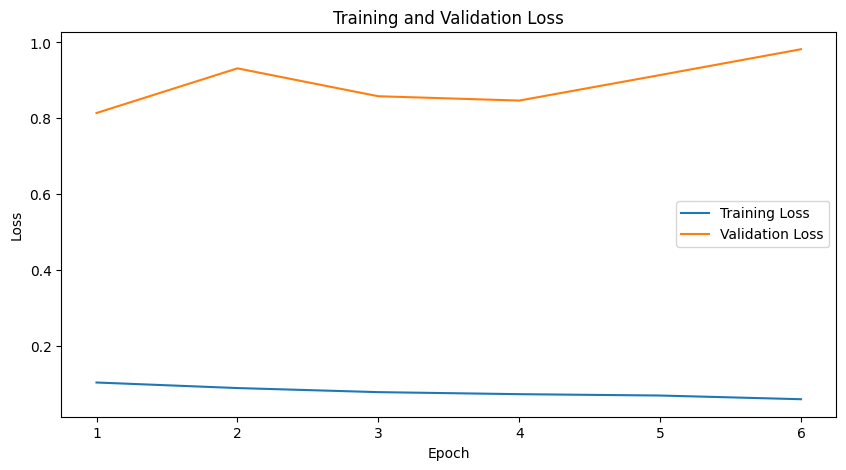

In [24]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with early stopping and plot the loss curves
num_epochs = 100
patience = 5
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)  

Evaluating: 100%|██████████| 67/67 [00:12<00:00,  5.29it/s]


Accuracy: 0.7864
Precision: 0.8063
Recall: 0.7864
F1 Score: 0.6631
AUC-ROC: 0.9311


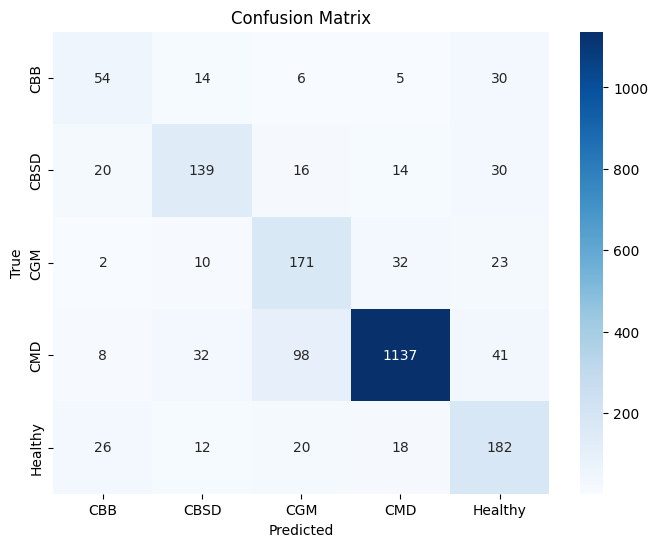

In [25]:
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
evaluate_model(model, test_loader, class_names)

**ResNet50**

In [26]:
# Load pre-trained ResNet-152
model = models.resnet50(pretrained=True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


In [28]:
# Modify the classifier to match the number of classes (2 in your case)
num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [29]:
# Training function with early stopping and loss plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_loss, 4)} | Validation Loss : {round(val_loss, 4)} | Train Accuracy : {round(train_acc * 100, 2)}% | Validation Accuracy : {round(val_acc * 100, 2)}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            print("Saving model....")
            torch.save(model.state_dict(), "resnet50_best_model.pt")  # Save the best model
        else:
            patience_counter += 1  # Increment counter if no improvement
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [30]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='macro')
    auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

    # Print
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.86it/s]


--> Epoch Number : 1 | Training Loss : 0.6022 | Validation Loss : 0.7121 | Train Accuracy : 78.15% | Validation Accuracy : 75.42%
Saving model....


Epoch 2/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


--> Epoch Number : 2 | Training Loss : 0.3198 | Validation Loss : 0.6859 | Train Accuracy : 88.76% | Validation Accuracy : 79.16%
Saving model....


Epoch 3/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


--> Epoch Number : 3 | Training Loss : 0.2161 | Validation Loss : 0.6607 | Train Accuracy : 92.57% | Validation Accuracy : 83.22%
Saving model....


Epoch 4/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.69it/s]


--> Epoch Number : 4 | Training Loss : 0.1657 | Validation Loss : 0.7058 | Train Accuracy : 94.32% | Validation Accuracy : 80.98%


Epoch 5/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.38it/s]


--> Epoch Number : 5 | Training Loss : 0.1342 | Validation Loss : 0.8265 | Train Accuracy : 95.44% | Validation Accuracy : 79.81%


Epoch 6/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.68it/s]


--> Epoch Number : 6 | Training Loss : 0.1174 | Validation Loss : 0.791 | Train Accuracy : 95.88% | Validation Accuracy : 81.36%


Epoch 7/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  6.90it/s]


--> Epoch Number : 7 | Training Loss : 0.1014 | Validation Loss : 0.7688 | Train Accuracy : 96.63% | Validation Accuracy : 81.26%


Epoch 8/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.43it/s]


--> Epoch Number : 8 | Training Loss : 0.0888 | Validation Loss : 0.8111 | Train Accuracy : 96.96% | Validation Accuracy : 83.32%
Early stopping triggered.


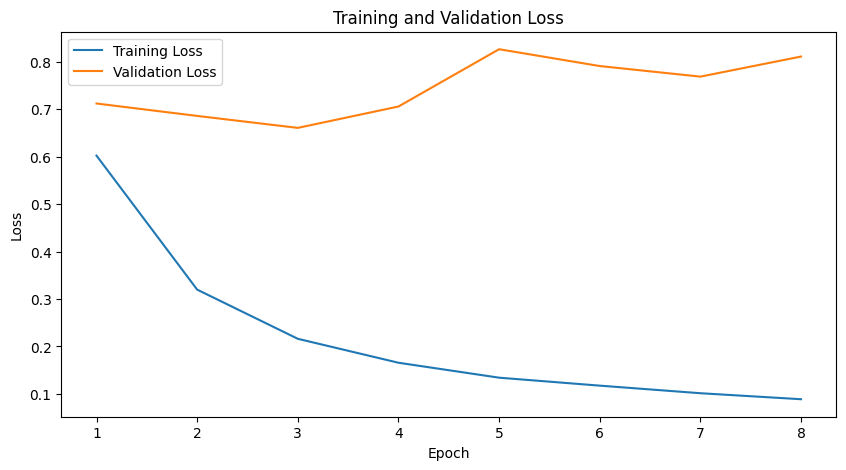

In [31]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with early stopping and plot the loss curves
num_epochs = 100
patience = 5
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)


Evaluating: 100%|██████████| 67/67 [00:11<00:00,  6.05it/s]


Accuracy: 0.8243
Precision: 0.8312
Recall: 0.8243
F1 Score: 0.6927
AUC-ROC: 0.9271


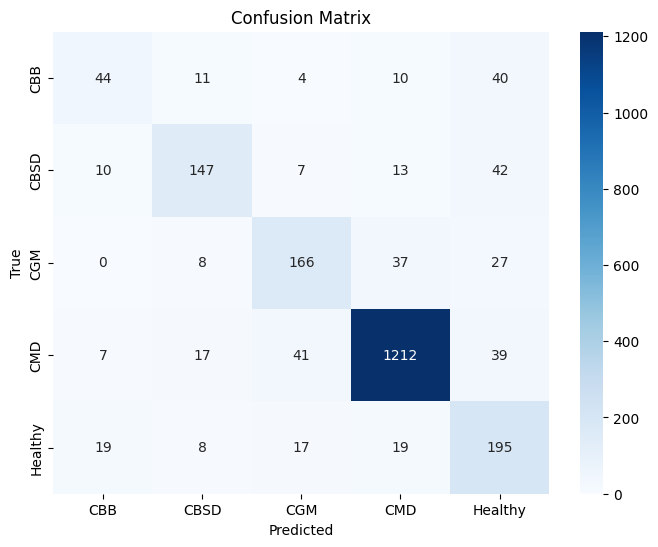

In [32]:
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
evaluate_model(model, test_loader, class_names)

**DenseNet121**

In [33]:
# Load pre-trained DenseNet-121
model = models.densenet121(pretrained=True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]


In [34]:

import torchvision.models as models
import torch.nn as nn

num_classes = 5
model = models.densenet121(pretrained=True)

# Update the classifier layer
model.classifier = nn.Linear(model.classifier.in_features, num_classes)


In [35]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)  # multiply by batch size
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"--> Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            print("Saving best model...")
            torch.save(model.state_dict(), "DenseNet121_best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses


In [36]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='macro')
    auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

    # Print
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.28it/s]


--> Epoch 1 | Train Loss: 0.5578 | Val Loss: 0.5957 | Train Acc: 79.75% | Val Acc: 79.63%
Saving best model...


Epoch 2/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  6.83it/s]


--> Epoch 2 | Train Loss: 0.2402 | Val Loss: 0.6503 | Train Acc: 91.67% | Val Acc: 80.33%


Epoch 3/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  6.82it/s]


--> Epoch 3 | Train Loss: 0.1452 | Val Loss: 0.6787 | Train Acc: 95.09% | Val Acc: 82.29%


Epoch 4/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  6.83it/s]


--> Epoch 4 | Train Loss: 0.1124 | Val Loss: 0.8333 | Train Acc: 96.16% | Val Acc: 80.61%


Epoch 5/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.46it/s]


--> Epoch 5 | Train Loss: 0.0867 | Val Loss: 0.7806 | Train Acc: 97.09% | Val Acc: 82.85%


Epoch 6/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.46it/s]


--> Epoch 6 | Train Loss: 0.0780 | Val Loss: 0.8165 | Train Acc: 97.32% | Val Acc: 82.06%
Early stopping triggered.


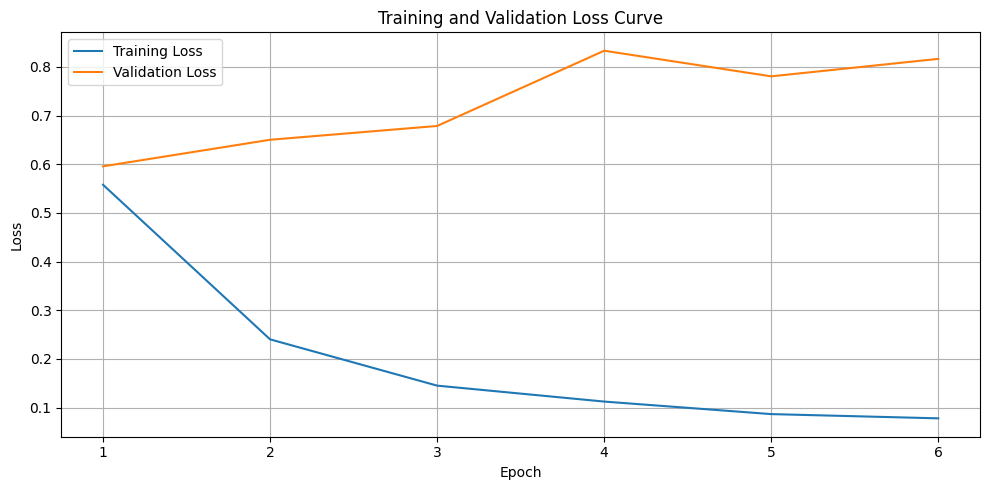

([0.5578389414505611,
  0.24024735498106708,
  0.1451597646447884,
  0.11241550810823371,
  0.08666734807200357,
  0.07796297809956713],
 [0.5957283495742584,
  0.6503005046153737,
  0.6786714380589601,
  0.8332692127361476,
  0.7806065492540877,
  0.8164968121831662])

In [37]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with early stopping and plot the loss curves
num_epochs = 100
patience = 5
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)


Evaluating: 100%|██████████| 67/67 [00:11<00:00,  5.95it/s]


Accuracy: 0.8322
Precision: 0.8371
Recall: 0.8322
F1 Score: 0.7110
AUC-ROC: 0.9387


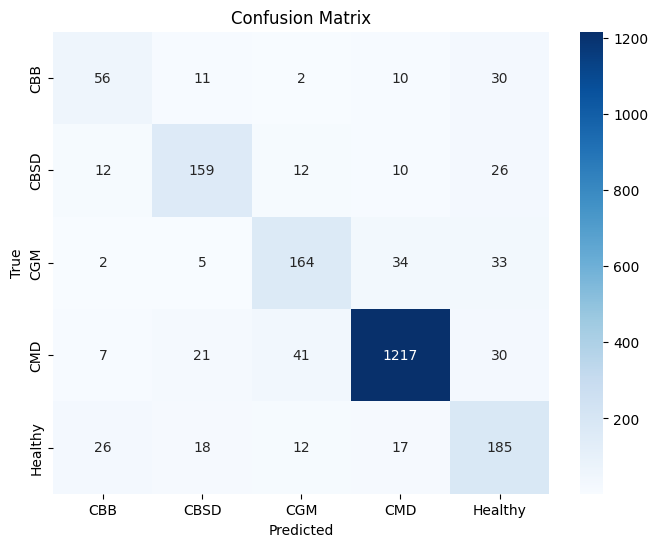

In [38]:
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
evaluate_model(model, test_loader, class_names)

**EfficientNetB0**

In [39]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_

In [40]:
from efficientnet_pytorch import EfficientNet

# Load pre-trained EfficientNet-B0 using the efficientnet-pytorch library
model = EfficientNet.from_pretrained('efficientnet-b0')
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 199MB/s]

Loaded pretrained weights for efficientnet-b0


In [41]:
from torchvision import models
import torch.nn as nn

model = models.efficientnet_b0(pretrained=True)
num_classes = 5
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 181MB/s]


In [42]:
# Training function with early stopping and loss plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_loss, 4)} | Validation Loss : {round(val_loss, 4)} | Train Accuracy : {round(train_acc * 100, 2)}% | Validation Accuracy : {round(val_acc * 100, 2)}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            print("Saving model....")
            torch.save(model.state_dict(), "EfficientNetB0_model.pt")  # Save the best model
        else:
            patience_counter += 1  # Increment counter if no improvement
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [43]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='macro')
    auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

    # Print
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.61it/s]


--> Epoch Number : 1 | Training Loss : 0.0414 | Validation Loss : 0.914 | Train Accuracy : 98.56% | Validation Accuracy : 84.49%
Saving model....


Epoch 2/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  6.91it/s]


--> Epoch Number : 2 | Training Loss : 0.0411 | Validation Loss : 0.8484 | Train Accuracy : 98.61% | Validation Accuracy : 84.58%
Saving model....


Epoch 3/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.61it/s]


--> Epoch Number : 3 | Training Loss : 0.0367 | Validation Loss : 0.9063 | Train Accuracy : 98.75% | Validation Accuracy : 84.77%


Epoch 4/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  6.91it/s]


--> Epoch Number : 4 | Training Loss : 0.0358 | Validation Loss : 0.9405 | Train Accuracy : 98.8% | Validation Accuracy : 84.49%


Epoch 5/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  7.07it/s]


--> Epoch Number : 5 | Training Loss : 0.0307 | Validation Loss : 0.9598 | Train Accuracy : 98.97% | Validation Accuracy : 85.37%


Epoch 6/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  6.93it/s]


--> Epoch Number : 6 | Training Loss : 0.0291 | Validation Loss : 1.029 | Train Accuracy : 98.98% | Validation Accuracy : 84.16%


Epoch 7/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  7.15it/s]


--> Epoch Number : 7 | Training Loss : 0.0288 | Validation Loss : 1.0559 | Train Accuracy : 99.05% | Validation Accuracy : 84.16%
Early stopping triggered.


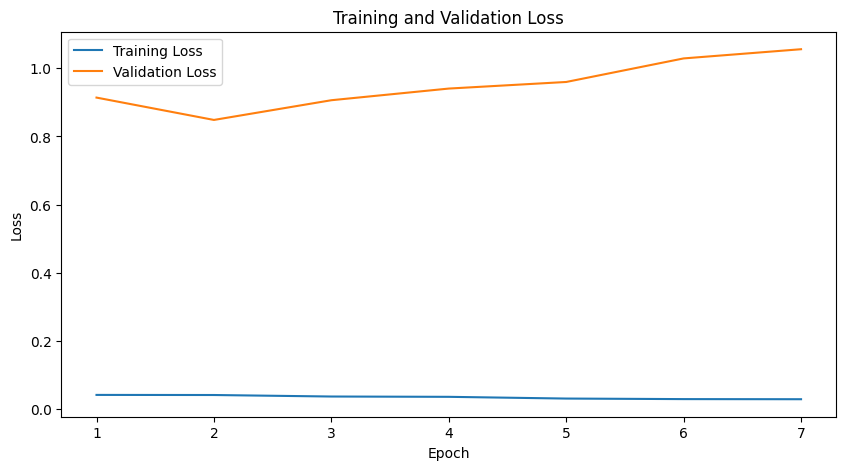

In [47]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with early stopping and plot the loss curves
num_epochs = 100
patience = 5
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)


Evaluating: 100%|██████████| 67/67 [00:10<00:00,  6.31it/s]


Accuracy: 0.8318
Precision: 0.8350
Recall: 0.8318
F1 Score: 0.7041
AUC-ROC: 0.9399


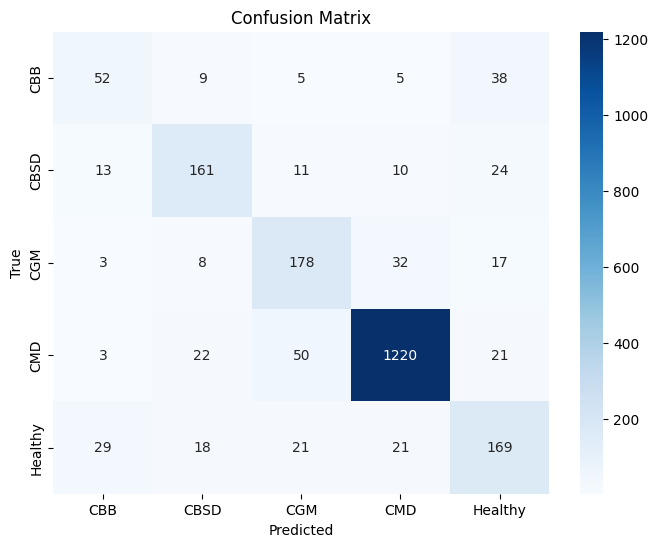

In [48]:
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
evaluate_model(model, test_loader, class_names)

**EfficientNetB3**

In [49]:
# Load pre-trained EfficientNet-B0 using the efficientnet-pytorch library
model = EfficientNet.from_pretrained('efficientnet-b3')
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 127MB/s] 


Loaded pretrained weights for efficientnet-b3


In [50]:
from torchvision import models
import torch.nn as nn

model = models.efficientnet_b3(pretrained=True)
num_classes = 5
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 197MB/s]


In [51]:
# Training function with early stopping and loss plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track accuracy and loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_loss, 4)} | Validation Loss : {round(val_loss, 4)} | Train Accuracy : {round(train_acc * 100, 2)}% | Validation Accuracy : {round(val_acc * 100, 2)}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            print("Saving model....")
            torch.save(model.state_dict(), "EfficientNetB3_model.pt")  # Save the best model
        else:
            patience_counter += 1  # Increment counter if no improvement
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [65]:
# Adjusted Evaluate Function
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(outputs, 1)  # Get the predicted class

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Handle multi-class AUC
    try:
        auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
        print(f"AUC-ROC: {auc_roc:.4f}")
    except ValueError:
        print("AUC-ROC: Not applicable (possibly due to single class in test set)")

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.43it/s]


--> Epoch Number : 1 | Training Loss : 0.675 | Validation Loss : 0.554 | Train Accuracy : 74.76% | Validation Accuracy : 81.31%
Saving model....


Epoch 2/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.64it/s]


--> Epoch Number : 2 | Training Loss : 0.2701 | Validation Loss : 0.6596 | Train Accuracy : 90.62% | Validation Accuracy : 80.93%


Epoch 3/100 - Validation: 100%|██████████| 67/67 [00:09<00:00,  6.98it/s]


--> Epoch Number : 3 | Training Loss : 0.1484 | Validation Loss : 0.6701 | Train Accuracy : 95.01% | Validation Accuracy : 82.76%


Epoch 4/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.65it/s]


--> Epoch Number : 4 | Training Loss : 0.1014 | Validation Loss : 0.7318 | Train Accuracy : 96.61% | Validation Accuracy : 82.71%


Epoch 5/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.46it/s]


--> Epoch Number : 5 | Training Loss : 0.0734 | Validation Loss : 0.7475 | Train Accuracy : 97.55% | Validation Accuracy : 84.25%


Epoch 6/100 - Validation: 100%|██████████| 67/67 [00:10<00:00,  6.37it/s]


--> Epoch Number : 6 | Training Loss : 0.0592 | Validation Loss : 0.8021 | Train Accuracy : 98.03% | Validation Accuracy : 83.27%
Early stopping triggered.


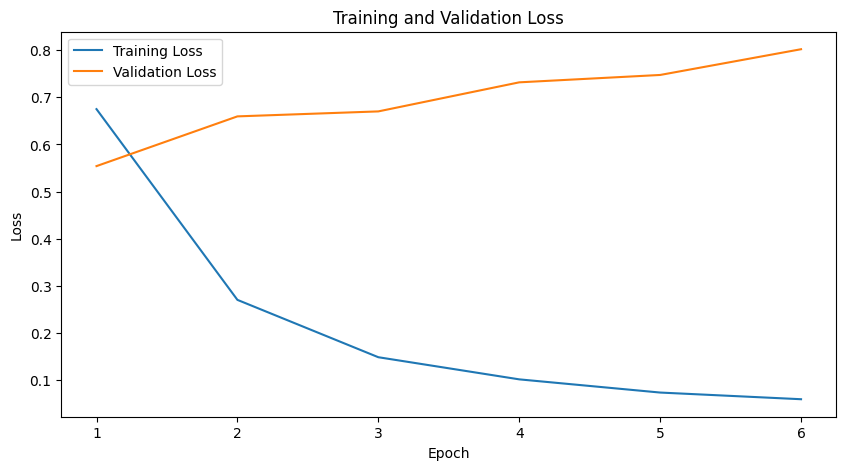

In [53]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with early stopping and plot the loss curves
num_epochs = 100
patience = 5
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)


Evaluating: 100%|██████████| 67/67 [00:10<00:00,  6.32it/s]


Accuracy: 0.8318
Precision: 0.8350
Recall: 0.8318
F1 Score: 0.7099
AUC-ROC: 0.9429


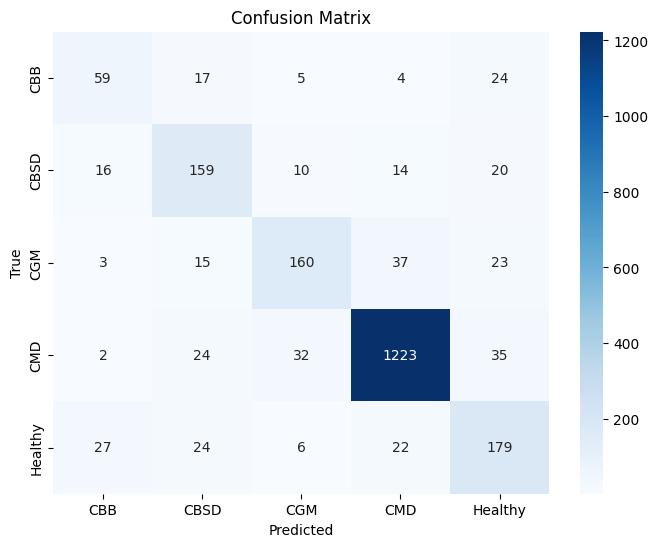

In [54]:
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
evaluate_model(model, test_loader, class_names)

**EfficinetNetViT**

In [55]:
import timm


In [56]:
# Define the model properly
model = timm.create_model('efficientvit_b3', pretrained=True)

# Send to GPU/CPU
model = model.to(device)


model.safetensors:   0%|          | 0.00/195M [00:00<?, ?B/s]

In [57]:
num_classes = 5
# EfficientViT's final classifier layer is a `ClassifierHead`, not a simple fully connected layer.
# The `ClassifierHead` has a `fc` attribute, which is the actual fully connected layer.
model.classifier = nn.Sequential(
    nn.Linear(model.num_features, 512),  # You can adjust the intermediate layer size
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)  # Final output layer for your classes
)
model = model.to(device)


In [58]:
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()

# Use SGD for better generalization with deep ResNet
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# StepLR reduces LR by factor of 0.1 every 5 epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


In [59]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, scheduler=None, device='cuda'):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"--> Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'efficientNetViT_best_model.pt')
            print("✔️ Model saved (new best validation loss)")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered")
                break

        # Step scheduler if provided
        if scheduler:
            scheduler.step()

    # Plot Loss
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [66]:
# Adjusted Evaluate Function
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, preds = torch.max(outputs, 1)  # Get the predicted class

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Handle multi-class AUC
    try:
        auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
        print(f"AUC-ROC: {auc_roc:.4f}")
    except ValueError:
        print("AUC-ROC: Not applicable (possibly due to single class in test set)")

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.98it/s]


--> Epoch 1/100 | Train Loss: 1.3321 | Val Loss: 1.4843 | Train Acc: 88.20% | Val Acc: 84.86%
✔️ Model saved (new best validation loss)


Epoch 2/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.99it/s]


--> Epoch 2/100 | Train Loss: 1.1220 | Val Loss: 1.5007 | Train Acc: 96.47% | Val Acc: 85.65%


Epoch 3/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.73it/s]


--> Epoch 3/100 | Train Loss: 1.0740 | Val Loss: 1.6021 | Train Acc: 98.11% | Val Acc: 84.02%


Epoch 4/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.87it/s]


--> Epoch 4/100 | Train Loss: 1.0582 | Val Loss: 1.6184 | Train Acc: 98.54% | Val Acc: 86.03%


Epoch 5/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.93it/s]


--> Epoch 5/100 | Train Loss: 1.0489 | Val Loss: 1.6391 | Train Acc: 98.88% | Val Acc: 86.21%


Epoch 6/100 - Validation: 100%|██████████| 67/67 [00:11<00:00,  5.70it/s]


--> Epoch 6/100 | Train Loss: 1.0439 | Val Loss: 1.6058 | Train Acc: 99.00% | Val Acc: 86.87%
⏹️ Early stopping triggered


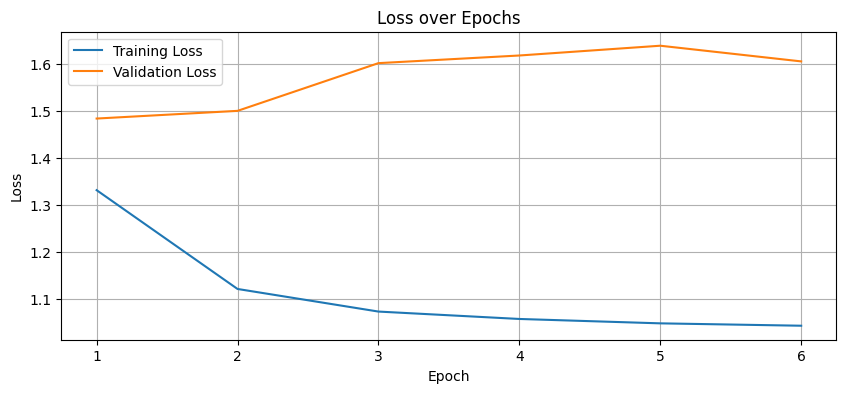

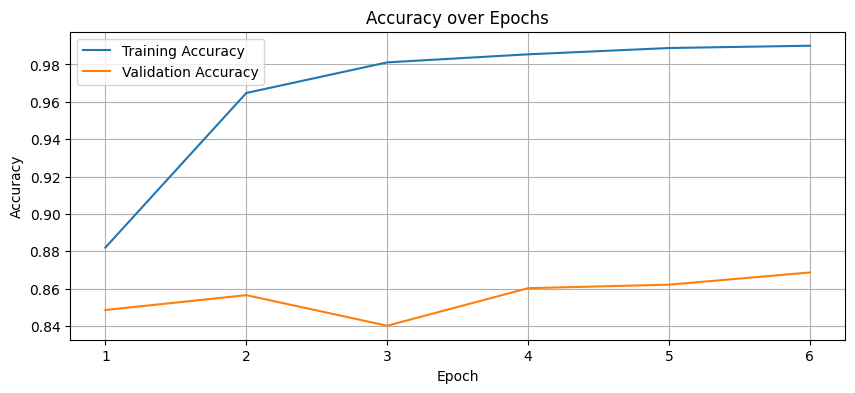

In [62]:
# Define training parameters
num_epochs = 100
patience = 5

# Define loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Train the model (note: scheduler is passed here)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience, scheduler=scheduler)


Evaluating: 100%|██████████| 67/67 [00:10<00:00,  6.34it/s]


AUC-ROC: Not applicable (possibly due to single class in test set)
Accuracy: 0.8565
Precision: 0.8557
Recall: 0.8565
F1 Score: 0.7485


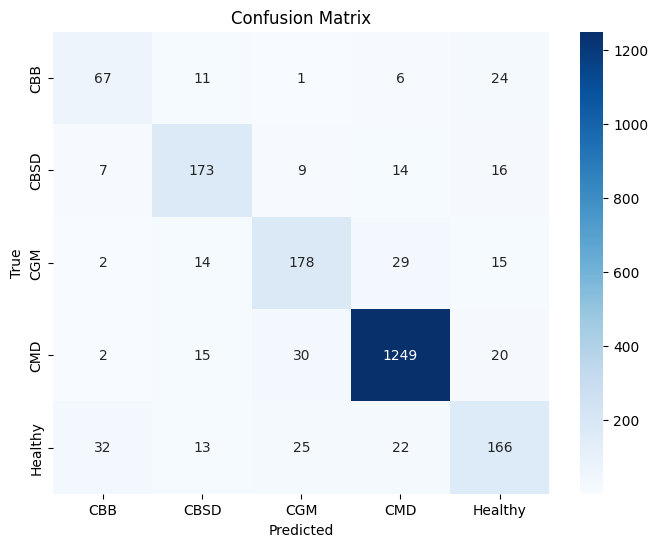

In [67]:
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
evaluate_model(model, test_loader, class_names)

**VIT**

In [68]:
import timm

# Load pre-trained EfficientViT from timm library (EfficientViT B0)
model = timm.create_model('vit_base_patch16_224', pretrained=True)  # Change to B1/B2 as needed
model = model.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [69]:
import torch.nn as nn

num_classes = 5

# Assuming model is a timm Vision Transformer
in_features = model.head.in_features

# 🔄 Replace the classifier *before* sending to device
model.head = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

# ✅ Move entire model (including new head) to device
model = model.to(device)

In [70]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, scheduler=None, device='cuda'):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"--> Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'viT_best_model.pt')
            print("✔️ Model saved (new best validation loss)")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered")
                break

        # Step scheduler if provided
        if scheduler:
            scheduler.step()

    # Plot Loss
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [71]:
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def evaluate_model(model, test_loader, class_names, device='cuda'):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # ✅ Support Hugging Face-style output or raw logits
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs

            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(logits, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # ✅ Classification metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    try:
        auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
        auc_text = f"{auc_roc:.4f}"
    except ValueError:
        auc_text = "N/A (Some classes missing in test set)"

    # ✅ Print metrics
    print(f"✅ Accuracy   : {accuracy:.4f}")
    print(f"✅ Precision  : {precision:.4f}")
    print(f"✅ Recall     : {recall:.4f}")
    print(f"✅ F1 Score   : {f1:.4f}")
    print(f"✅ AUC-ROC    : {auc_text}")

    # ✅ Confusion matrix heatmap
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

Epoch 1/100 - Validation: 100%|██████████| 67/67 [00:13<00:00,  4.84it/s]


--> Epoch 1/100 | Train Loss: 0.9664 | Val Loss: 0.8314 | Train Acc: 71.00% | Val Acc: 78.93%
✔️ Model saved (new best validation loss)


Epoch 2/100 - Validation: 100%|██████████| 67/67 [00:13<00:00,  4.84it/s]


--> Epoch 2/100 | Train Loss: 0.7329 | Val Loss: 0.8029 | Train Acc: 83.70% | Val Acc: 81.21%
✔️ Model saved (new best validation loss)


Epoch 3/100 - Validation: 100%|██████████| 67/67 [00:13<00:00,  4.85it/s]


--> Epoch 3/100 | Train Loss: 0.6237 | Val Loss: 0.8544 | Train Acc: 89.05% | Val Acc: 79.44%


Epoch 4/100 - Validation: 100%|██████████| 67/67 [00:13<00:00,  4.87it/s]


--> Epoch 4/100 | Train Loss: 0.5704 | Val Loss: 0.8164 | Train Acc: 91.82% | Val Acc: 81.21%


Epoch 5/100 - Validation: 100%|██████████| 67/67 [00:13<00:00,  4.86it/s]


--> Epoch 5/100 | Train Loss: 0.5381 | Val Loss: 0.8726 | Train Acc: 93.35% | Val Acc: 79.58%


Epoch 6/100 - Validation: 100%|██████████| 67/67 [00:13<00:00,  4.86it/s]


--> Epoch 6/100 | Train Loss: 0.5185 | Val Loss: 0.8769 | Train Acc: 94.30% | Val Acc: 78.83%


Epoch 7/100 - Validation: 100%|██████████| 67/67 [00:13<00:00,  4.87it/s]


--> Epoch 7/100 | Train Loss: 0.5025 | Val Loss: 0.8611 | Train Acc: 95.04% | Val Acc: 79.95%
⏹️ Early stopping triggered


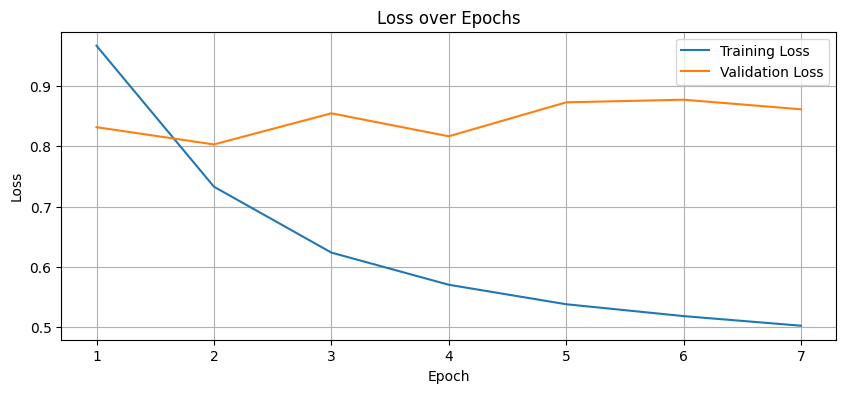

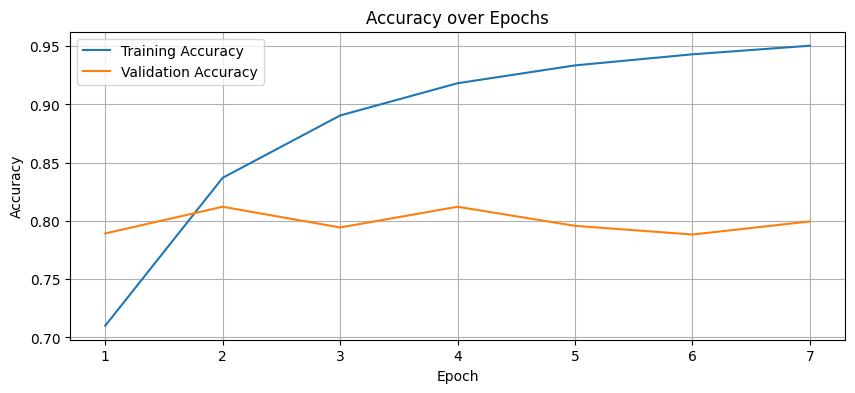

In [72]:
# Define training parameters
num_epochs = 100
patience = 5

# Define loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Train the model (note: scheduler is passed here)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience, scheduler=scheduler)

Evaluating: 100%|██████████| 67/67 [00:13<00:00,  4.86it/s]


✅ Accuracy   : 0.7925
✅ Precision  : 0.8024
✅ Recall     : 0.7925
✅ F1 Score   : 0.6461
✅ AUC-ROC    : 0.9072


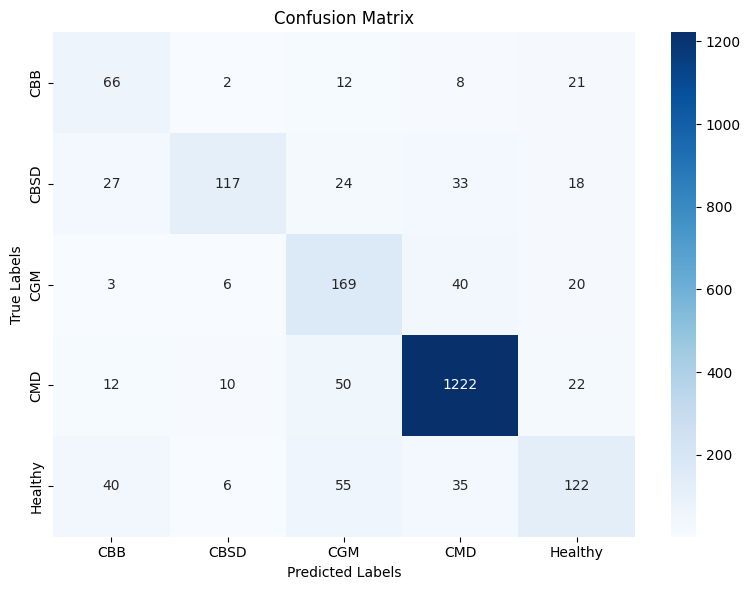

In [73]:
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
evaluate_model(model, test_loader, class_names)